# NBA Shot Prediction

This notebook aims to predict the likelyhood of a shot beeing a hit, based on parameters like the distance, the clock, the touch time and the distance of the closees defender.

We use two different ML algorythms: Logistic Regression as a baseline and XGBoost as more advanced model

In [27]:
import pandas as pd
import numpy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

## Load data and Exploration

In [28]:
df = pd.read_csv('../input/nba-shot-logs/shot_logs.csv')
df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [29]:
df.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'player_name', 'player_id'],
      dtype='object')

0    66622
1    55880
Name: FGM, dtype: int64

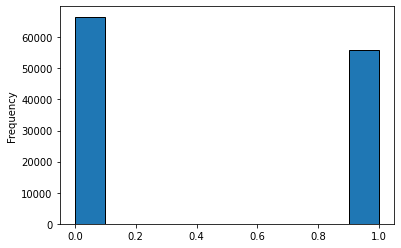

In [35]:
df['FGM'].plot(kind='hist', edgecolor='black')
df['FGM'].value_counts()

By always predicting that the shot misses, you get an accuracy of about 0.54.

## Preparation

In [41]:
df.dropna(subset=['SHOT_DIST', 'TOUCH_TIME', 'CLOSE_DEF_DIST', 'SHOT_CLOCK', 'DRIBBLES', 'FGM'], inplace=True)
X = df[['SHOT_DIST', 'TOUCH_TIME', 'CLOSE_DEF_DIST','DRIBBLES', 'SHOT_CLOCK']]
X = pd.get_dummies(data=X, drop_first=True)
y = df['FGM']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=101, 
                                   test_size=0.2, 
                                   shuffle=True)

## Train Models

### Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver="saga")
lr.fit(X_train, y_train)

lr_y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, lr_y_pred)

print('The basic Logistic Regression model has accuracy of: ', accuracy)
precision = precision_score(y_test, y_pred)

print('The basic Logistic Regression model has precision of: ', precision)

# since the shot results are relatively balanced, we stick to accuracy

The basic Logistic Regression model has accuracy of:  0.6047100118362516
The basic Logistic Regression model has precision of:  0.6346183381968976


### XGBoost

In [43]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('The basic XGBoost model has accuracy of: ', accuracy)
precision = precision_score(y_test, y_pred)

print('The basic XGBoost model has precision of: ', precision)

The basic XGBoost model has accuracy of:  0.612056650748949
The basic XGBoost model has precision of:  0.6346183381968976


In [50]:
# XGBoost optimization

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }



def objective(space):
    xgb=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), 
                    eval_metric="auc", early_stopping_rounds=10)
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    xgb.fit(X_train, y_train,
            eval_set=evaluation,verbose=False)
    

    pred = xgb.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }


In [51]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)



SCORE:                                                 
0.61246479735521                                       
SCORE:                                                                          
0.611607689482062                                                               
SCORE:                                                                          
0.6120158360883229                                                              
SCORE:                                                                          
0.6119342067670708                                                              
SCORE:                                                                          
0.6115260601608098                                                              
SCORE:                                                                          
0.6126280559977144                                                              
SCORE:                                                                        

In [53]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7615166102818351, 'gamma': 3.3944534748573156, 'max_depth': 5.0, 'min_child_weight': 6.0, 'reg_alpha': 175.0, 'reg_lambda': 0.582815796942114}


In [55]:
xgb_final=XGBClassifier(
                    n_estimators = 180, max_depth = int(best_hyperparams['max_depth']), gamma = best_hyperparams['gamma'],
                    reg_alpha = int(best_hyperparams['reg_alpha']),min_child_weight=int(best_hyperparams['min_child_weight']),
                    colsample_bytree=int(best_hyperparams['colsample_bytree']), 
                    eval_metric="auc", early_stopping_rounds=10)
evaluation = [( X_train, y_train), ( X_test, y_test)]
    
xgb_final.fit(X_train, y_train,
            eval_set=evaluation,verbose=False)
    

xgb_y_pred = xgb_final.predict(X_test)
accuracy = accuracy_score(y_test, xgb_y_pred)
print('The final XGBoost model has an accuracy of: ', accuracy)

The final XGBoost model has an accuracy of:  0.6129137586220971


## Visualize the Results

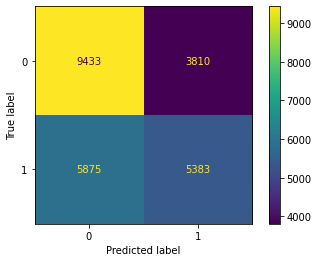

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm_lr = confusion_matrix(y_test, lr_y_pred, labels=lr.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=lr.classes_)
disp.plot()
plt.show()

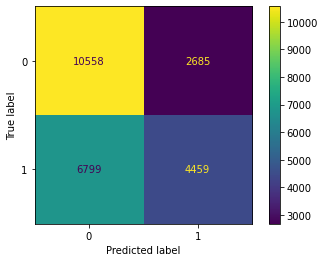

In [58]:
cm_xgb = confusion_matrix(y_test, xgb_y_pred, labels=xgb_final.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_final.classes_)
disp.plot()
plt.show()

The results show, that the XGBoost model has a slightly better accuracy. the confusion Matrix also shows, thta the XGB classifies more shots as misses than the Logistic Regression.